<a href="https://colab.research.google.com/github/bagas30h/dataset_ros2/blob/main/train_behavior_cloning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/bagas30h/dataset.git

fatal: destination path 'dataset' already exists and is not an empty directory.


In [ ]:
ls dataset

driving_log.csv  IMG/  README.md


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg, imageio
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
import pandas as pd
import ntpath
import random

In [ ]:
datadir = 'dataset'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', None)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,D:\dataset\IMG\center_2024_09_03_15_31_11_508.jpg,D:\dataset\IMG\left_2024_09_03_15_31_11_508.jpg,D:\dataset\IMG\right_2024_09_03_15_31_11_508.jpg,0.0,0.0,0.0,2.226257e-07
1,D:\dataset\IMG\center_2024_09_03_15_31_11_575.jpg,D:\dataset\IMG\left_2024_09_03_15_31_11_575.jpg,D:\dataset\IMG\right_2024_09_03_15_31_11_575.jpg,0.0,0.0,0.0,9.310539e-07
2,D:\dataset\IMG\center_2024_09_03_15_31_11_647.jpg,D:\dataset\IMG\left_2024_09_03_15_31_11_647.jpg,D:\dataset\IMG\right_2024_09_03_15_31_11_647.jpg,0.0,0.0,0.0,4.185975e-06
3,D:\dataset\IMG\center_2024_09_03_15_31_11_717.jpg,D:\dataset\IMG\left_2024_09_03_15_31_11_717.jpg,D:\dataset\IMG\right_2024_09_03_15_31_11_717.jpg,0.0,0.0,0.0,4.917305e-06
4,D:\dataset\IMG\center_2024_09_03_15_31_11_784.jpg,D:\dataset\IMG\left_2024_09_03_15_31_11_784.jpg,D:\dataset\IMG\right_2024_09_03_15_31_11_784.jpg,0.0,0.0,0.0,3.985586e-06


In [ ]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2024_09_03_15_31_11_508.jpg,left_2024_09_03_15_31_11_508.jpg,right_2024_09_03_15_31_11_508.jpg,0.0,0.0,0.0,2.226257e-07
1,center_2024_09_03_15_31_11_575.jpg,left_2024_09_03_15_31_11_575.jpg,right_2024_09_03_15_31_11_575.jpg,0.0,0.0,0.0,9.310539e-07
2,center_2024_09_03_15_31_11_647.jpg,left_2024_09_03_15_31_11_647.jpg,right_2024_09_03_15_31_11_647.jpg,0.0,0.0,0.0,4.185975e-06
3,center_2024_09_03_15_31_11_717.jpg,left_2024_09_03_15_31_11_717.jpg,right_2024_09_03_15_31_11_717.jpg,0.0,0.0,0.0,4.917305e-06
4,center_2024_09_03_15_31_11_784.jpg,left_2024_09_03_15_31_11_784.jpg,right_2024_09_03_15_31_11_784.jpg,0.0,0.0,0.0,3.985586e-06


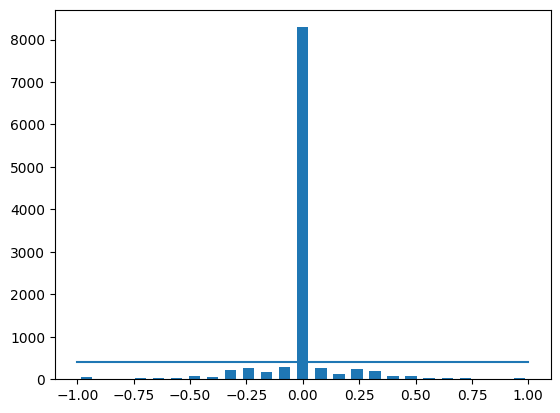

In [ ]:
num_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))
# plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

removed: 7888
remaining: 2708


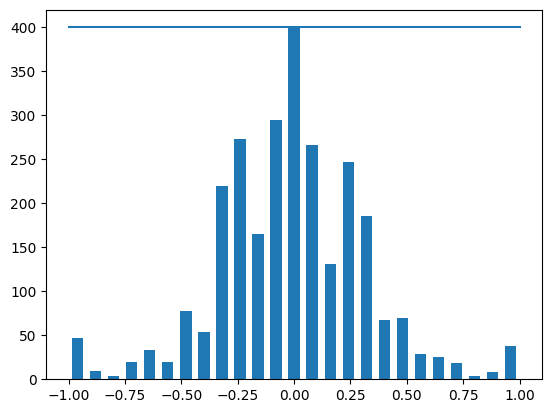

In [ ]:
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'].iloc[i] >= bins[j] and data['steering'].iloc[i] <= bins[j+1]: # Use iloc to access elements by position
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)
print('removed:', len(remove_list))

data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))

hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [ ]:
print(data.iloc[1])
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

image_path, steerings = load_img_steering(datadir + '/IMG', data)

center      center_2024_09_03_15_31_12_565.jpg
left          left_2024_09_03_15_31_12_565.jpg
right        right_2024_09_03_15_31_12_565.jpg
steering                                 -0.35
throttle                              0.499521
reverse                                    0.0
speed                                  0.53572
Name: 15, dtype: object


<ipython-input-58-8af079b264fd>:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
<ipython-input-58-8af079b264fd>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  steering.append(float(indexed_data[3]))


In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(image_path, steerings, test_size=0.2, random_state=6)
print('Training Samples: {}\nValid Samples: {}'.format(len(x_train), len(x_valid)))

Training Samples: 2166
Valid Samples: 542


Text(0.5, 1.0, 'Validation set')

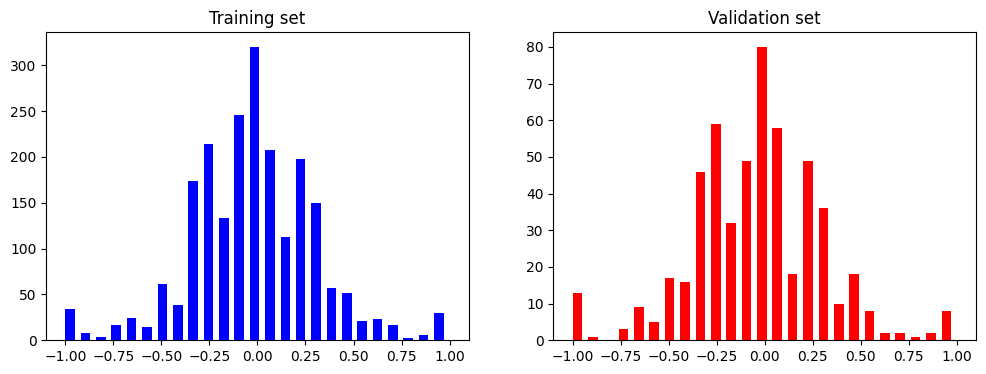

In [ ]:
fig, axis = plt.subplots(1, 2, figsize=(12, 4))
axis[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axis[0].set_title('Training set')
axis[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axis[1].set_title('Validation set')

In [ ]:
def img_preprocess(img):
  img = mpimg.imread(img)
  return img

Text(0.5, 1.0, 'Preprocessed Image')

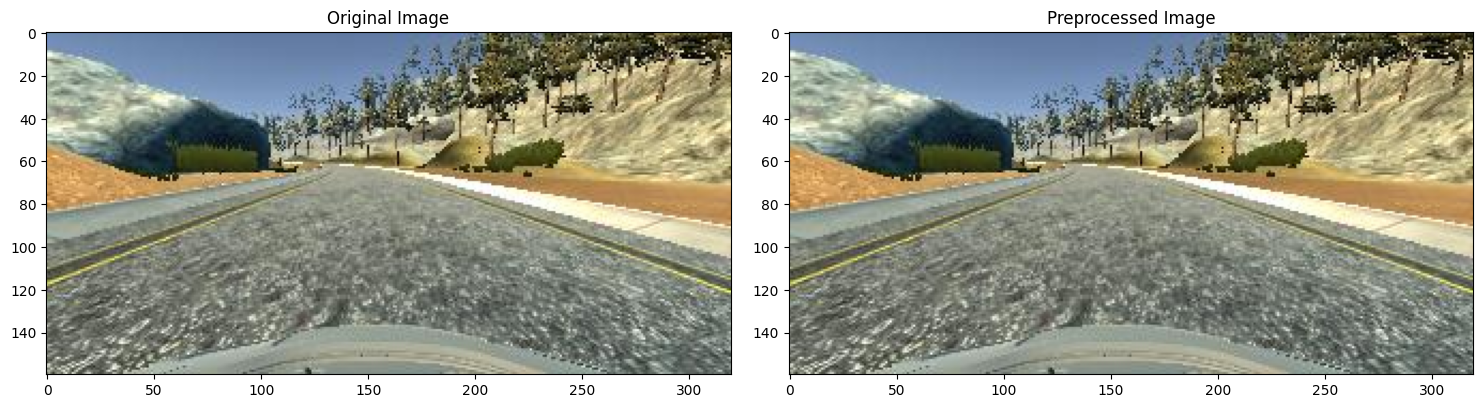

In [ ]:
image = image_path[50]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(image)
fig, axis = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axis[0].imshow(original_image)
axis[0].set_title('Original Image')
axis[1].imshow(preprocessed_image)
axis[1].set_title('Preprocessed Image')

In [ ]:
def img_preprocess(img):
  img = mpimg.imread(img)
  img = img[60:135, :, :]
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img, (3, 3), 0)
  img = cv2.resize(img, (200, 66))
  img = img/255
  return img

Text(0.5, 1.0, 'Preprocessed Image')

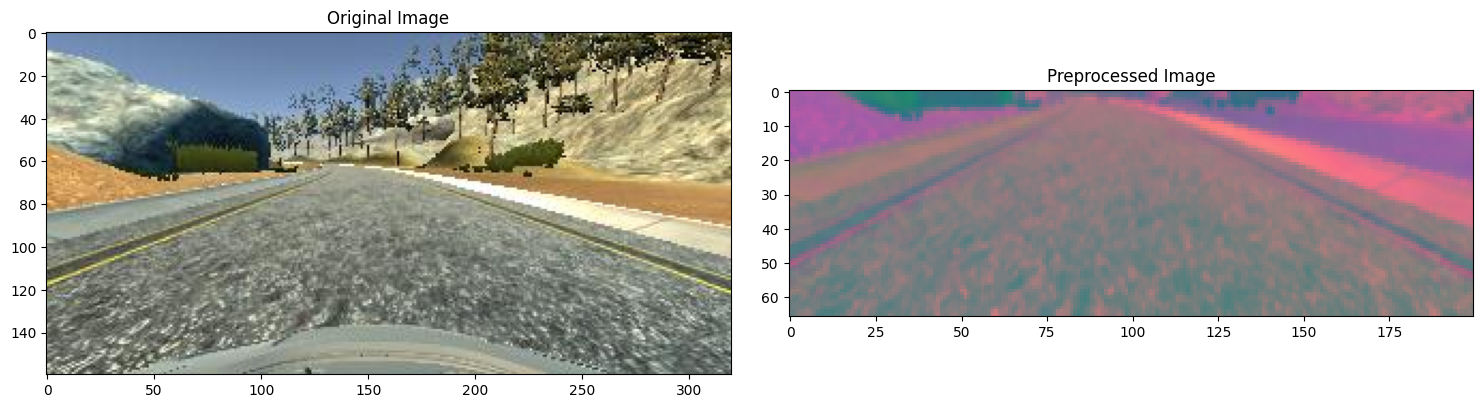

In [ ]:
image = image_path[50]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(image)
fig, axis = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axis[0].imshow(original_image)
axis[0].set_title('Original Image')
axis[1].imshow(preprocessed_image)
axis[1].set_title('Preprocessed Image')

In [ ]:
x_train = np.array(list(map(img_preprocess, x_train)))
x_valid = np.array(list(map(img_preprocess, x_valid)))

(2166, 66, 200, 3)


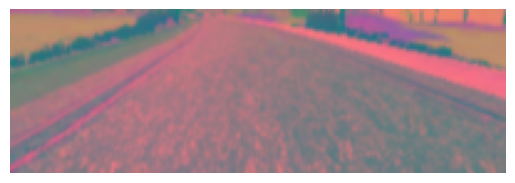

In [ ]:
plt.imshow(x_train[random.randint(0, len(x_train) - 1)])
plt.axis('off')
print(x_train.shape)
#

In [ ]:
def nvidia_model():
  model = Sequential()

  model.add(Conv2D(24, kernel_size=(5,5), strides=(2,2), input_shape=(66,200,3),activation='relu'))

  model.add(Conv2D(36, kernel_size=(5,5), strides=(2,2), activation='elu'))
  model.add(Conv2D(48, kernel_size=(5,5), strides=(2,2), activation='elu'))
  model.add(Conv2D(64, kernel_size=(3,3), activation='elu'))
  model.add(Conv2D(64, kernel_size=(3,3), activation='elu'))
  model.add(Dropout(0.5))


  model.add(Flatten())

  model.add(Dense(100, activation='elu'))
  model.add(Dropout(0.5))


  model.add(Dense(50, activation='elu'))
  model.add(Dropout(0.5))

  model.add(Dense(10, activation ='elu'))
  model.add(Dropout(0.5))

  model.add(Dense(1))


  optimizer= Adam(learning_rate=1e-3) # Change 'lr' to 'learning_rate'
  model.compile(loss='mse', optimizer=optimizer)

  return model

In [ ]:
model = nvidia_model()
print(model.summary())

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_40 (Conv2D)                   │ (None, 31, 98, 24)          │           1,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_41 (Conv2D)                   │ (None, 14, 47, 36)          │          21,636 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_42 (Conv2D)                   │ (None, 5, 22, 48)           │          43,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_43 (Conv2D)                   │ (None, 3, 20, 64)           │          27,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_44 (Conv2D)                   │ (None, 1, 18, 64)           │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 1, 18, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 100)                 │         115,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 10)                  │             510 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 252,219 (985.23 KB)

 Trainable params: 252,219 (985.23 KB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
history = model.fit(x_train, y_train, epochs=40, validation_data=(x_valid, y_valid), batch_size=100, verbose=1, shuffle=1)

Epoch 1/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 652ms/step - loss: 1.0517 - val_loss: 0.1148
Epoch 2/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 14s 662ms/step - loss: 0.1251 - val_loss: 0.1131
Epoch 3/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 20s 649ms/step - loss: 0.1073 - val_loss: 0.1141
Epoch 4/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 20s 614ms/step - loss: 0.1079 - val_loss: 0.1113
Epoch 5/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 21s 639ms/step - loss: 0.1000 - val_loss: 0.1103
Epoch 6/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 14s 645ms/step - loss: 0.1020 - val_loss: 0.1066
Epoch 7/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 20s 601ms/step - loss: 0.1078 - val_loss: 0.1005
Epoch 8/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 21s 632ms/step - loss: 0.0978 - val_loss: 0.0969
Epoch 9/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 14s 638ms/step - loss: 0.0923 - val_loss: 0.0846
Epoch 10/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 23s 761ms/step - loss: 0.0924 - val_loss: 0.0800
Epoch 11/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 14s 624ms/step - loss: 0.0833 - val_loss: 0.0807
Epoch 12/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 14

Text(0.5, 0, 'Epoch')

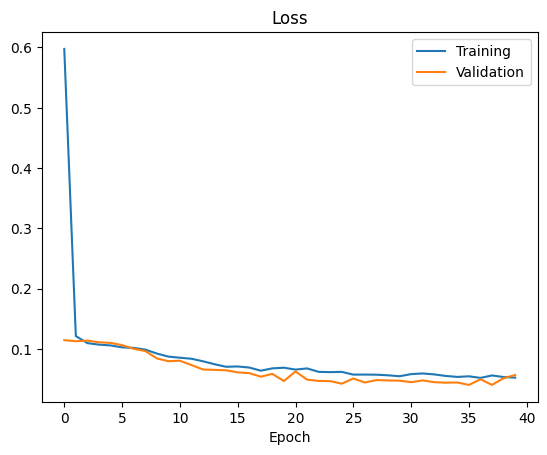

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [ ]:
model.save('model40.h5')

In [ ]:
from google.colab import files
files.download('model40.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>